# 0a. Plot kinematics

For this script we need installed AGAMA code by Vasiliev (2019).

Paper: https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1525V

Code: http://github.com/GalacticDynamics-Oxford/Agama

In [15]:
import os
import pathlib
import zipfile
from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd

import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from astropy_healpix import HEALPix

import agama

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

import config
import utils

In [16]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

## Read in the RGB stars catalogue

In [17]:
# Use necessary columns only
columns = ['source_id', 'l', 'b', 'parallax', 'parallax_error', 'dist', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'mh_xgboost']
df = pd.read_hdf(cache_path / 'rgb.hdf5', key='rgb', columns=columns)

# Metallicity range to select
mh_lo_lim, mh_hi_lim = -3.0, 0.5
# Select stars by metallicity
mask = (mh_lo_lim <= df['mh_xgboost']) & (df['mh_xgboost'] < mh_hi_lim)
df = df[mask].copy()

print("Num. of stars after cleaning and selection:", len(df))

Num. of stars after cleaning and selection: 17553412


## Download catalogue of globular clusters by Vasiliev & Baumgardt (2021)

Paper: https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5978V

Data: https://doi.org/10.5281/zenodo.4891252

In [18]:
# Download
url = 'https://zenodo.org/records/4891252/files/clusters.zip'
file_name = cache_path / 'Vasiliev2021_clusters.zip'
utils.download_file(url, file_name)

# Extract
gc_path = cache_path / file_name.stem
with zipfile.ZipFile(file_name, 'r') as zf:
    zf.extractall(path=gc_path)

Starting download from https://zenodo.org/records/4891252/files/clusters.zip
File 'cache/Vasiliev2021_clusters.zip' already downloaded
Done


In [19]:
# Read in the GCs catalogue

fnames = [ f.name  for f in (gc_path / 'catalogues').glob(f"*.txt") ]
print("len(fnames) =", len(fnames))

gc = pd.DataFrame()
for fname in fnames:
    gc_ = pd.read_csv(gc_path / 'catalogues' / fname, delimiter='\s+', comment='#',
                      names=['source_id', 'ra', 'dec', 'x', 'y', 'plx', 'pmra', 'pmdec', 'plxe', 'pmrae', 'pmdece', 'pmcorr',
                             'g_mag', 'bp_rp', 'Sigma', 'qflag', 'memberprob'],
                      dtype={'source_id': int, 'qflag': int})
    gc = pd.concat([gc, gc_[['source_id', 'memberprob']]], ignore_index=True)
print("Num. of GC stars:", len(gc))


len(fnames) = 170
Num. of GC stars: 2343282


## Clean RGB catalogue

In [20]:
# Clean-out NaNs
mask = df['vx'].isna() | df['vy'].isna() | df['vz'].isna()
df = df[~mask].copy()
print("Num. of stars after cleaning:", len(df))

Num. of stars after cleaning: 12573822


In [21]:
"""
# More cleaning

# Use more strict parallaxes
mask = df['parallax'] > 10*df['parallax_error']
df = df[mask].copy()

# Remove the very Galactic plane
mask = np.abs(df['b']) < 10.0
df = df[~mask].copy()

mask = np.fabs(df['z']) < 2.5
df = df[mask].copy()

print("Num. of stars after more cleaning:", len(df))
"""

'\n# Some cleaning\n\n# Use more strict parallaxes\nmask = df[\'parallax\'] > 10*df[\'parallax_error\']\ndf = df[mask].copy()\n\n# Remove the very Galactic plane\nmask = np.abs(df[\'b\']) < 10.0\ndf = df[~mask].copy()\n\nmask = np.fabs(df[\'z\']) < 2.5\ndf = df[mask].copy()\n\nprint("Num. of stars after more cleaning:", len(df))\n'

In [23]:
# Cut SMC and LMC

# SMC
co = SkyCoord(16.26*u.deg, -72.42*u.deg, frame='icrs')
l0, b0 = co.galactic.l.value, co.galactic.b.value
mask = np.sqrt((df['l']-l0)**2 + (df['b']-b0)**2) < 8.0
df = df[~mask].copy()

# LMC
co = SkyCoord(78.77*u.deg, -69.01*u.deg, frame='icrs')
l0, b0 = co.galactic.l.value, co.galactic.b.value
mask = np.sqrt((df['l']-l0)**2 + (df['b']-b0)**2) < 12.0
df = df[~mask].copy()

print("Num. of stars after SMC+LMC cut:", len(df))

Num. of stars after SMC+LMC cut: 12539107


In [24]:
# Cut GC stars
mask = ~df['source_id'].isin(gc['source_id'])
df = df[mask].copy()
print("Num. of stars after GC cut:", len(df))

Num. of stars after GC cut: 12524006


## Calculate kinematics

In [25]:
kinem_path = cache_path / 'rgb_kinem.hdf5'

if os.path.exists(kinem_path):
    df = pd.read_hdf(kinem_path, key='rgb')
    print(df.columns)

else:
    pot = agama.Potential(str(cache_path / 'MWPotentialHunter24_rotating.ini'))

    # Galactocentric distance in the Spherical coordinates
    #df['r'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    # Galactocentric distance in the Cylindrical coordinates
    df['R'] = np.sqrt(df['x']**2 + df['y']**2)
    # Galactocentric velocities in Cylindrical coordinates
    df['vR']   = (df['x']*df['vx'] + df['y']*df['vy']) / df['R']
    df['vphi'] = -(df['x']*df['vy'] - df['y']*df['vx']) / df['R']
    # Angular momentum
    df['Lz'] = df['R'] * df['vphi']

    num_threads = 12  # Set this parameter according to your PC
    with agama.setNumThreads(num_threads):
        print("E ...")
        df['E'] = 0.5*(df['vx']**2 + df['vy']**2 + df['vz']**2) + pot.potential(df[['x', 'y', 'z']])
        print("periapo ...")
        periapo = pot.Rperiapo(df[['E', 'Lz']])
        df['peri'] = periapo[:,0]
        df['apo']  = periapo[:,1]
        print("rcirc ...")
        df['rcirc'] = pot.Rcirc(E=df['E'])
        print("tcirc ...")
        df['tcirc'] = pot.Tcirc(df['E'])

    # Angular momentum on circular orbits
    df['Lc'] = 2*np.pi*df['rcirc']**2 / df['tcirc']
    df['eta'] = df['Lz']/df['Lc']

    # Eccentricity
    x = df['apo']/df['peri']
    df['ecc'] = (x - 1) / (x + 1)

    # Save kinematics
    df.to_hdf(kinem_path, key='rgb', mode='w', index=False)

E ...
periapo ...
rcirc ...
tcirc ...


## Plot

In [26]:
def plot_hist2d(df, x, y, map_, x_edges, y_edges, ax=None, colnorm=True, maskzeros=True, cb=False, **kwargs):
    if ax is None:
        ax = plt.gca()
    tmp = df.groupby([x, y], observed=False).agg(val=map_)
    val = pd.DataFrame(tmp).reset_index().pivot(index=y, columns=x, values='val').astype(float).values
    if colnorm:
        val_min = val.min(axis=0)[np.newaxis,:]
        val_max = val.max(axis=0)[np.newaxis,:]
        val = (val - val_min) / (val_max - val_min)
    if maskzeros:
        val[np.where(val == 0)] = np.nan
    im = ax.pcolormesh(x_edges, y_edges, val, rasterized=True, **kwargs)
    if cb:
        plt.colorbar(im, ax=ax)


In [27]:
# Bin

mask = df['ecc'].isna()
df = df[~mask].copy()

mh_nbins = 91
other_nbins = 61

df['mh_'], mh_edges   = pd.cut(df['mh_xgboost'], bins=mh_nbins, retbins=True)
df['Lz_'], Lz_edges   = pd.cut(df['Lz']/1e3, bins=np.linspace(-2.0, 4.0, other_nbins), retbins=True)
df['E_'], E_edges   = pd.cut(df['E']/1e5, bins=np.linspace(-2.4, -0.8, other_nbins), retbins=True)
df['eta_'], eta_edges = pd.cut(df['eta'], bins=np.linspace(-1.0, 1.0, other_nbins), retbins=True)
#df['apo_'], apo_edges = pd.cut(df['apo'], bins=np.linspace(0.0, 10**1.5, other_nbins), retbins=True)
#df['apo_'], apo_edges = pd.cut(df['apo'], bins=np.logspace(np.log10(0.5), 1.5, other_nbins), retbins=True)
df['apo_'], apo_edges = pd.cut(df['apo'], bins=np.logspace(np.log10(2.33), 1.5, other_nbins), retbins=True)
df['ecc_'], ecc_edges = pd.cut(df['ecc'], bins=np.linspace(0.0, 1.0, other_nbins), retbins=True)

### [M/H] vs kinematics

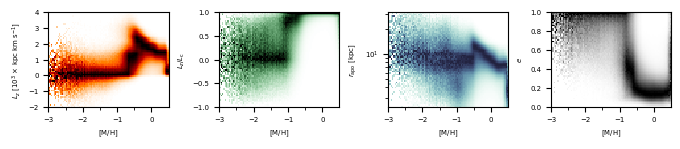

In [28]:
df_ = df
#mask = df['parallax_over_error'] > 10
#df_ = df[mask]


plt.rc('font', size=5.0)
inch = 2.54  ## cm
#width, height = 17/inch, 5.69/inch
width, height = 17/inch, 3.5/inch
plt.figure(figsize=(width, height), layout='constrained')

plt.subplot(1, 4, 1)
cmap = 'gist_heat_r'
plot_hist2d(df_, 'mh_', 'Lz_', ('mh_', 'size'), mh_edges, Lz_edges, cmap=cmap)
#plt.axvline(0.45, ls=':', lw=0.5, c='m')
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$L_z$ [$10^3\times$ kpc km s$^{-1}$]")

plt.subplot(1, 4, 2)
#cmap = sns.color_palette('rocket_r', as_cmap=True)
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=1.0, as_cmap=True)
plot_hist2d(df_, 'mh_', 'eta_', ('mh_', 'size'), mh_edges, eta_edges, cmap=cmap)
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$L_z/L_\mathrm{c}$")

plt.subplot(1, 4, 3)
#cmap = 'cubehelix_r'
#cmap = sns.color_palette('mako_r', as_cmap=True)
#cmap = sns.color_palette("Blues", as_cmap=True)
cmap = sns.color_palette("ch:start=.1,rot=-.3,light=1.0", as_cmap=True)
plot_hist2d(df_, 'mh_', 'apo_', ('mh_', 'size'), mh_edges, apo_edges, cmap=cmap)
#plt.axvline(0.45, ls=':', lw=0.5, c='m')
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$r_\mathrm{apo}$ [kpc]")
plt.yscale('log')

plt.subplot(1, 4, 4)
cmap = 'gist_yarg'
plot_hist2d(df_, 'mh_', 'ecc_', ('mh_', 'size'), mh_edges, ecc_edges, cmap=cmap)
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$e$")

plt.savefig(fig_path / 'data-kinem-mh.pdf')
plt.show()
plt.close()

### [M/H] vs kinematics splitted by R

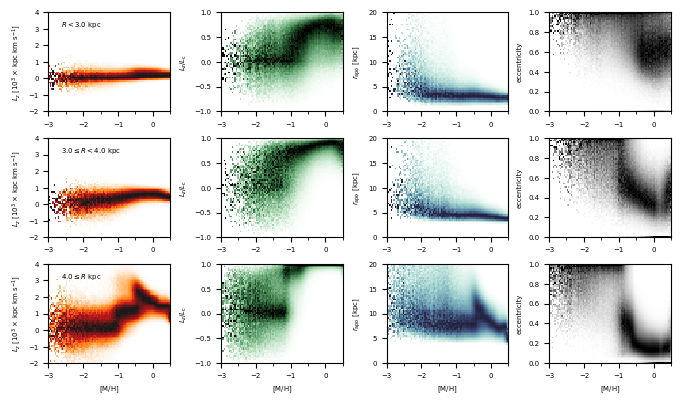

In [29]:
def plot_row(df_, axrow):

    ax_ = axrow[0]
    hist, lz_edges, mh_edges = np.histogram2d(df_['Lz']/1e3, df_['mh_xgboost'], range=((-2.0, 4.0), (-3.0, 0.5)), bins=(60, 90))
    hist_min = hist.min(axis=0)[np.newaxis,:]
    hist_max = hist.max(axis=0)[np.newaxis,:]
    hist = (hist - hist_min) / (hist_max - hist_min)
    cmap = 'gist_heat_r'
    ax_.pcolormesh(mh_edges, lz_edges, hist, cmap=cmap, alpha=0.9, rasterized=True)
    ax_.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax_.set_ylabel(r"$L_z$ [$10^3\times$ kpc km s$^{-1}$]")

    ax_ = axrow[1]
    hist, lzlc_edges, mh_edges = np.histogram2d(df_['Lz']/df_['Lc'], df_['mh_xgboost'], range=((-1.0, 1.0), (-3.0, 0.5)), bins=(60, 90))
    hist_min = hist.min(axis=0)[np.newaxis,:]
    hist_max = hist.max(axis=0)[np.newaxis,:]
    hist = (hist - hist_min) / (hist_max - hist_min)
    cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=1.0, as_cmap=True)
    ax_.pcolormesh(mh_edges, lzlc_edges, hist, cmap=cmap, rasterized=True)
    ax_.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax_.set_ylabel(r"$L_z/L_\mathrm{c}$")

    ax_ = axrow[2]
    hist, rapo_edges, mh_edges = np.histogram2d(df_['apo'], df_['mh_xgboost'], range=((0.0, 20.0), (-3.0, 0.5)), bins=(60, 90))
    hist_min = hist.min(axis=0)[np.newaxis,:]
    hist_max = hist.max(axis=0)[np.newaxis,:]
    hist = (hist - hist_min) / (hist_max - hist_min)
    cmap = sns.color_palette("ch:start=.1,rot=-.3,light=1.0", as_cmap=True)
    ax_.pcolormesh(mh_edges, rapo_edges, hist, cmap=cmap, rasterized=True)
    ax_.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax_.set_ylabel(r"$r_\mathrm{apo}$ [kpc]")

    ax_ = axrow[3]
    hist, rapo_edges, mh_edges = np.histogram2d(df_['ecc'], df_['mh_xgboost'], range=((0.0, 1.0), (-3.0, 0.5)), bins=(60, 90))
    hist_min = hist.min(axis=0)[np.newaxis,:]
    hist_max = hist.max(axis=0)[np.newaxis,:]
    hist = (hist - hist_min) / (hist_max - hist_min)
    cmap = 'gist_yarg'
    ax_.pcolormesh(mh_edges, rapo_edges, hist, cmap=cmap, rasterized=True)
    ax_.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax_.set_ylabel(r"eccentricity")


r_cut1, r_cut2 = 3.0, 4.0


plt.rc('font', size=5.0)
inch = 2.54  ## cm
width, height = 17/inch, 10/inch
#plt.figure(figsize=(width, height), layout='constrained')
_, ax = plt.subplots(3, 4, figsize=(width, height), layout='constrained')

mask = df['R'] < r_cut1
plot_row(df[mask], ax[0])
ax[0,0].annotate(r"$R < {}$ kpc".format(r_cut1), xy=(0.1, 0.85), xycoords='axes fraction')

mask = (r_cut1 <= df['R']) & (df['R'] < r_cut2)
plot_row(df[mask], ax[1])
ax[1,0].annotate(r"${} \leq R < {}$ kpc".format(r_cut1, r_cut2), xy=(0.1, 0.85), xycoords='axes fraction')

mask = r_cut2 <= df['R']
plot_row(df[mask], ax[2])
ax[2,0].annotate(r"${} \leq R$ kpc".format(r_cut2), xy=(0.1, 0.85), xycoords='axes fraction')

for ax_ in ax[-1]:
    ax_.set_xlabel(r"$[\mathrm{M}/\mathrm{H}]$")


plt.savefig(fig_path / 'data-kinem-mh-rsplit.pdf')
plt.show()
plt.close()

### [M/H] vs kinematics colored by log10(rapo)

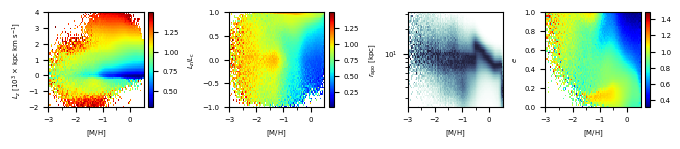

In [30]:
log10median = lambda x : np.median(np.log10(x))


mask = df['apo'] < 10**1.5
#mask &= df['parallax_over_error'] > 10
df_ = df[mask]

plt.rc('font', size=5.0)
inch = 2.54  ## cm
#width, height = 17/inch, 5.69/inch
width, height = 17/inch, 3.5/inch
plt.figure(figsize=(width, height), layout='constrained')

cmap = 'jet'

plt.subplot(1, 4, 1)
plot_hist2d(df_, 'mh_', 'Lz_', ('apo', log10median), mh_edges, Lz_edges, cmap=cmap, colnorm=False, cb=True)
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$L_z$ [$10^3\times$ kpc km s$^{-1}$]")

plt.subplot(1, 4, 2)
plot_hist2d(df_, 'mh_', 'eta_', ('apo', log10median), mh_edges, eta_edges, cmap=cmap, colnorm=False, cb=True)
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$L_z/L_\mathrm{c}$")

plt.subplot(1, 4, 3)
cmap_ = sns.color_palette("ch:start=.1,rot=-.3,light=1.0", as_cmap=True)
plot_hist2d(df_, 'mh_', 'apo_', ('mh_', 'size'), mh_edges, apo_edges, cmap=cmap_)
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$r_\mathrm{apo}$ [kpc]")
plt.yscale('log')

plt.subplot(1, 4, 4)
plot_hist2d(df_, 'mh_', 'ecc_', ('apo', log10median), mh_edges, ecc_edges, cmap=cmap, colnorm=False, cb=True)
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$e$")

plt.savefig(fig_path / 'data-kinem-mh-logapocolor.pdf')
plt.show()
plt.close()

### L_z/L_c vs rapo

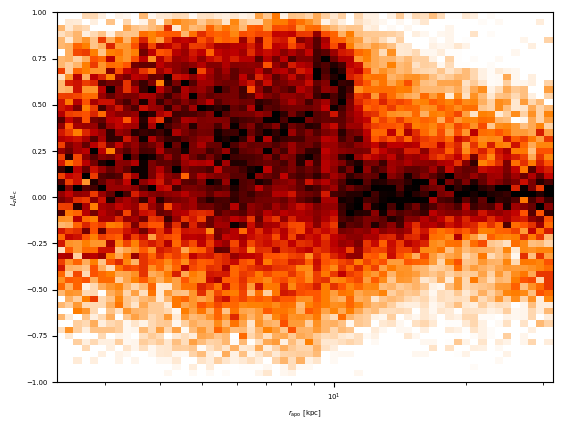

In [31]:
mask = (-2.0 < df['mh_xgboost']) & (df['mh_xgboost'] <= -1.5)
#mask &= df['parallax_over_error'] > 10
df_ = df[mask]

plt.figure()

plot_hist2d(df_, 'apo_', 'eta_', ('apo_', 'size'), apo_edges, eta_edges, cmap='gist_heat_r')
plt.xlabel(r"$r_\mathrm{apo}$ [kpc]")
plt.xscale('log')
plt.ylabel(r"$L_z/L_\mathrm{c}$")

plt.show()
plt.close()

### Kinematics diagram

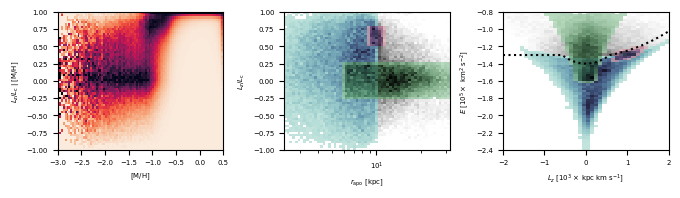

In [32]:
plt.rc('font', size=5.0)
inch = 2.54  ## cm
width, height = 17/inch, 4.75/inch
plt.figure(figsize=(width, height), layout='constrained')

#
# eta vs [M/H]

plt.subplot(1, 3, 1)

df_ = df

ax = plt.gca()
cmap = 'gist_yarg'
cmap = 'gist_heat_r'
cmap = sns.color_palette("rocket_r", as_cmap=True)
plot_hist2d(df_, 'mh_', 'eta_', ('mh_', 'size'), mh_edges, eta_edges, ax=ax, cmap=cmap, maskzeros=False)
plt.xlabel(r"$[\mathrm{M}/\mathrm{H}]$")
plt.xlim(-3.0, 0.5)
plt.gca().xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
plt.ylabel(r"$L_z/L_\mathrm{c}\;|\;[\mathrm{M}/\mathrm{H}]$")


#
# eta vs r_apo

plt.subplot(1, 3, 2)
ax = plt.gca()

mh_lo_lim_, mh_hi_lim_ = -2.0, -1.5
#mh_lo_lim_, mh_hi_lim_ = -3.0, -2.0
mask = (mh_lo_lim_ < df['mh_xgboost']) & (df['mh_xgboost'] <= mh_hi_lim_) & (df['apo'] < 10**1.5)
#mask &= df['parallax_over_error'] > 10
df_ = df[mask]

# All
cmap = 'gist_yarg'
plot_hist2d(df_, 'apo_', 'eta_', ('apo_', 'size'), apo_edges, eta_edges, ax=ax, cmap=cmap, colnorm=False)

# Aurora
mask = df_['apo'] < 10.0
df__ = df_[mask]
cmap = sns.color_palette("ch:start=0.1,rot=-0.3,dark=0.1,light=0.85", as_cmap=True)
plot_hist2d(df__, 'apo_', 'eta_', ('apo_', 'size'), apo_edges, eta_edges, ax=ax, cmap=cmap, colnorm=False)

# GSE
mask = (6.0 < df_['apo']) & (df_['apo'] < 35.0) & (-0.25 < df_['eta']) & (df_['eta'] < 0.25)
df__ = df_[mask]
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.0, light=0.75, as_cmap=True)
plot_hist2d(df__, 'apo_', 'eta_', ('apo_', 'size'), apo_edges, eta_edges, ax=ax, cmap=cmap, alpha=0.7, colnorm=False)

# Captured
mask = (0.95 < np.log10(df_['apo'])) & (np.log10(df_['apo']) < 1.05) & (0.5 < df_['eta']) & (df_['eta'] < 0.8)
df__ = df_[mask]
cmap = sns.cubehelix_palette(dark=0.1, light=0.75, as_cmap=True)
plot_hist2d(df__, 'apo_', 'eta_', ('apo_', 'size'), apo_edges, eta_edges, ax=ax, cmap=cmap, alpha=0.7, colnorm=False)

ax.set_xlabel(r"$r_\mathrm{apo}$ [kpc]")
ax.set_xscale('log')
ax.set_ylabel(r"$L_z/L_\mathrm{c}$")


#
# E vs L_z

plt.subplot(1, 3, 3)
ax = plt.gca()

# All
cmap = 'gist_yarg'
plot_hist2d(df_, 'Lz_', 'E_', ('Lz_', 'size'), Lz_edges, E_edges, ax=ax, cmap=cmap, colnorm=False)

# Aurora
mask = df_['apo'] < 10.0
df__ = df_[mask]
cmap = sns.color_palette("ch:start=0.1,rot=-0.3,dark=0.1,light=0.85", as_cmap=True)
plot_hist2d(df__, 'Lz_', 'E_', ('Lz_', 'size'), Lz_edges, E_edges, ax=ax, cmap=cmap, colnorm=False)

# GSE
mask = (6.0 < df_['apo']) & (df_['apo'] < 35.0) & (-0.25 < df_['eta']) & (df_['eta'] < 0.25)
df__ = df_[mask]
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.0, light=0.75, as_cmap=True)
plot_hist2d(df__, 'Lz_', 'E_', ('Lz_', 'size'), Lz_edges, E_edges, ax=ax, cmap=cmap, alpha=0.7, colnorm=False)

# Captured
mask = (0.95 < np.log10(df_['apo'])) & (np.log10(df_['apo']) < 1.05) & (0.5 < df_['eta']) & (df_['eta'] < 0.8)
df__ = df_[mask]
cmap = sns.cubehelix_palette(dark=0.1, light=0.75, as_cmap=True)
plot_hist2d(df__, 'Lz_', 'E_', ('Lz_', 'size'), Lz_edges, E_edges, ax=ax, cmap=cmap, alpha=0.7, colnorm=False)

ax.set_xlabel(r"$L_z$ [$10^3\times$ kpc km s$^{-1}$]")
plt.xlim(-2.0, 2.0)
ax.set_ylabel(r"$E$ [$10^5\times$ km$^2$ s$^{-2}$]")

# Plot the decision boundary to separate stars into accreted (high energy) and Aurora (in-situ, low energy populations)
# Belokurov, Kravtsov (2023) https://arxiv.org/abs/2306.00060

Lz = np.linspace(-2.0, 2.0, 200)

E = np.empty_like(Lz)
#
mask = Lz <= -0.58
E[mask] = -1.3
#
mask = (-0.58 < Lz) & (Lz < 0.58)
E[mask] = -1.4 + 0.3*Lz[mask]**2
#
mask = Lz > 0.58
E[mask] = -1.325 + 0.075*Lz[mask]**2

ax.plot(Lz, E, ':k')


plt.savefig(fig_path / 'data-kinem-all.pdf')
plt.show()
plt.close()